In [209]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import pandas as pd
from scipy.interpolate import griddata
%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

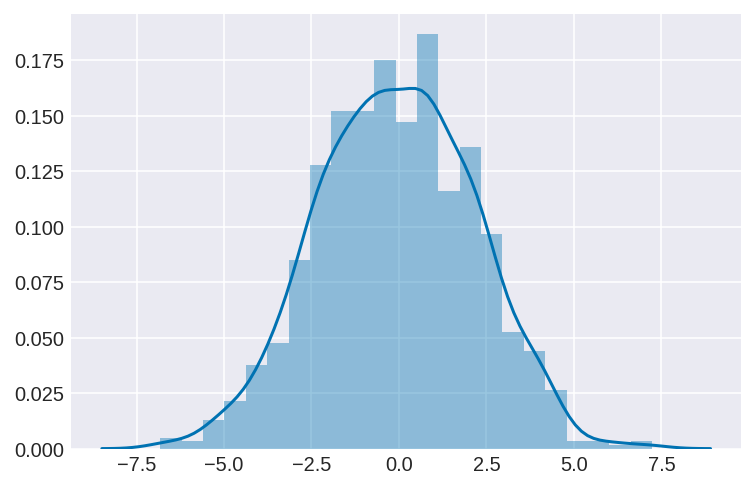

In [210]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0) #Using uniform distribuition
sns.distplot(pos)

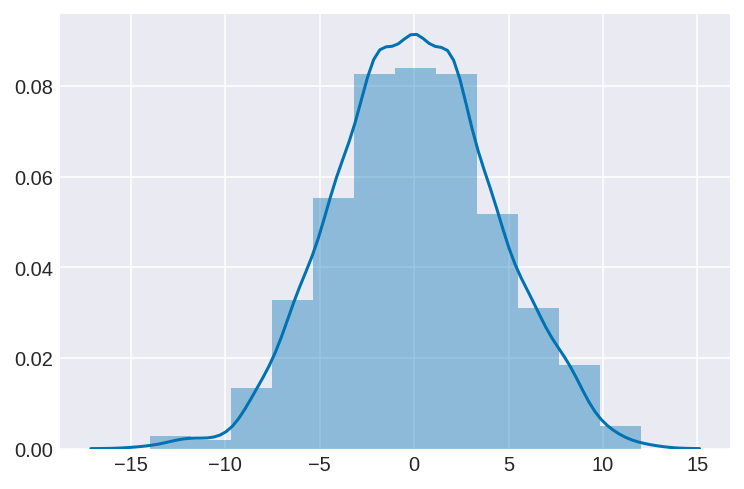

In [211]:
pos = np.random.choice(np.array([-1,1]),p=np.array([0.5,0.5]),size=(16,1000)).sum(0) #Using discrete steps
sns.distplot(pos,bins=12)

"Any process that adds together random values from the same distribution converges to
a normal."

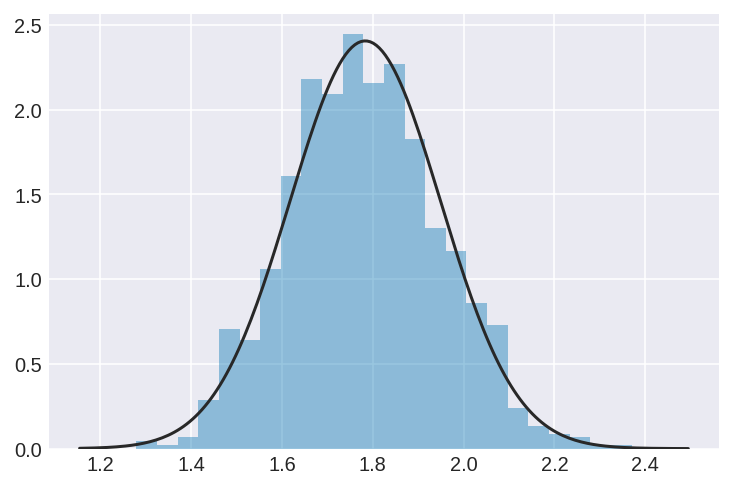

In [212]:
# The Normal distribution emerges as distributions are added
# If one instead of summing the values sampled, multiply them, given that the multiplication factor is small,
# the central limit theorem still works, but less so as the multiplication effect increases

pos = np.random.uniform(1.0, 1.1, size=(12, 1000)).prod(0) #Using uniform distribuition
sns.distplot(pos,fit=norm,kde=False)

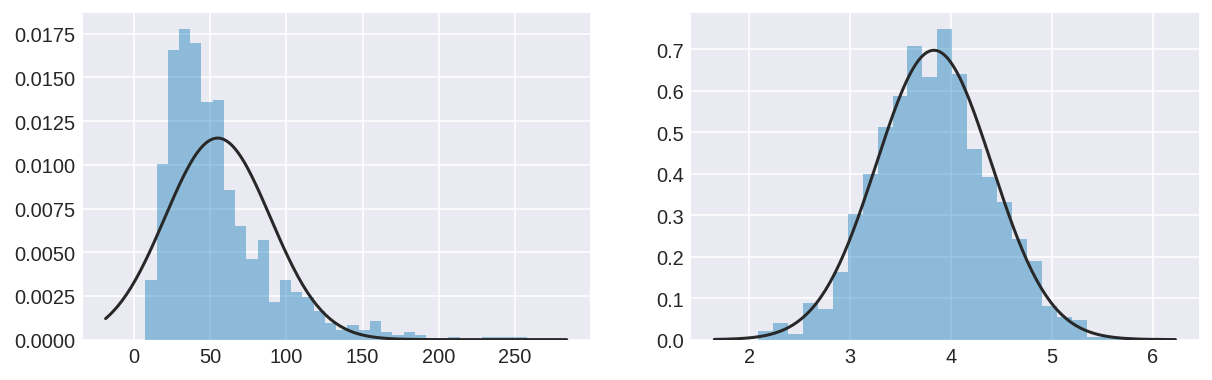

In [213]:
# Multiplying each occurance will make the samples deviate from the normal.
# Still, one can use the log-normal for such cases.
# It is interesting to notice that there is a speed for the Central Limit Theorem to occur,
# And for distributions with infinite variance of no mean, the Central Limit Theorem will never take place
# as in the case of Cauchy Distribution

_,(ax0,ax1)=plt.subplots(1,2,figsize=(10,3))
pos = np.random.uniform(1.0, 1.8, size=(12, 1000)).prod(0) 
poslog = np.log(np.random.uniform(1.0, 1.8, size=(12, 1000)).prod(0)) 
sns.distplot(pos,fit=norm,kde=False,ax=ax0)
sns.distplot(poslog,fit=norm,kde=False,ax=ax1)

### Linear regression

In [214]:
df = pd.read_csv("Data/Howell1.csv",sep=';')

In [215]:
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [216]:
d2 = df[df.age >= 18]

Note: Be aware of E.T Jaynes' mind projection fallacy. "It occurs when someone thinks that the way they see the world reflects the way the world really is, going as far as assuming the real existence of imagined objects."

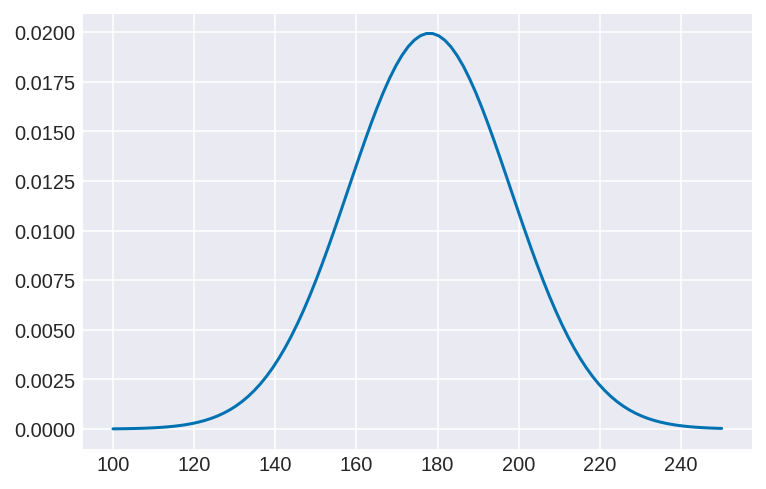

In [241]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20))

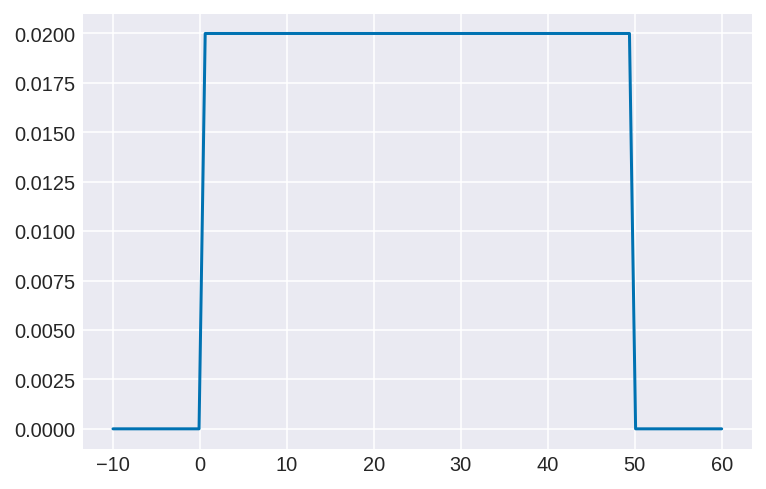

In [218]:
plt.plot(np.linspace(-10,60,100),stats.uniform.pdf(np.linspace(-10,60,100),0,50))

In [219]:
samples_mu = np.random.normal(178,20,size=10000)
samples_sigma = np.random.uniform(0,50,size=10000)
prior = stats.norm.rvs(loc=samples_mu,scale=samples_sigma,size=10000)

177.71277449396533
34.90831070640679


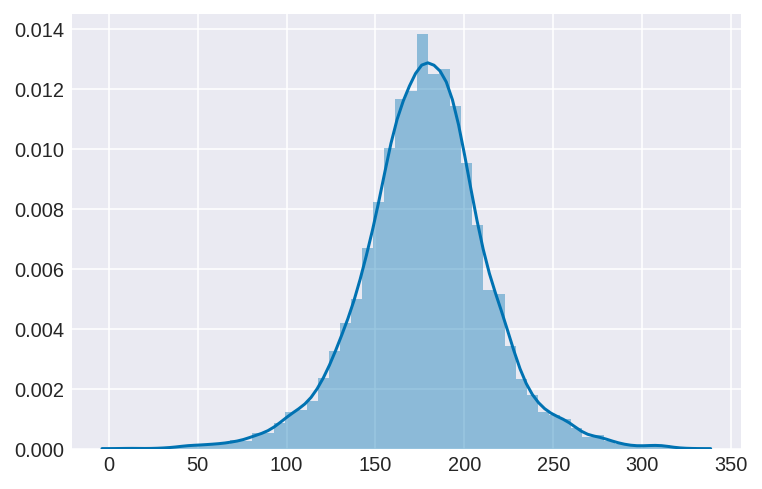

In [220]:
sns.distplot(prior)
print(prior.mean())
print(prior.std())

In [140]:
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

likelihood = [sum(stats.norm.logpdf(d2.height, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod = (likelihood + 
             stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
             stats.uniform.logpdf(post[:,1], loc=0, scale=50))
post_prob = np.exp(post_prod - max(post_prod))

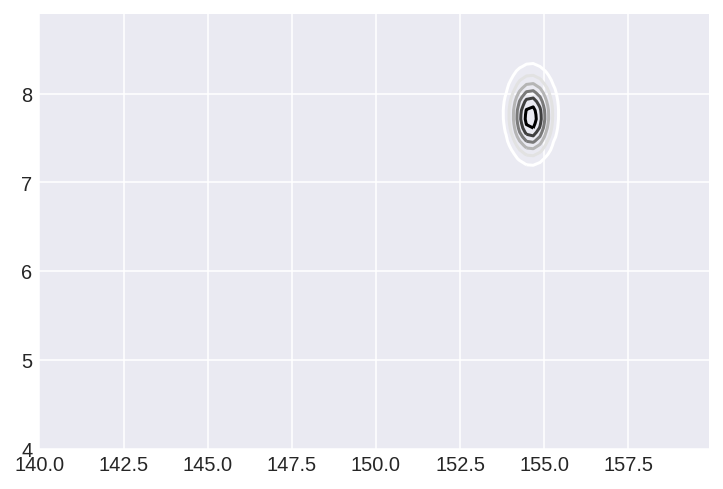

In [143]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi)


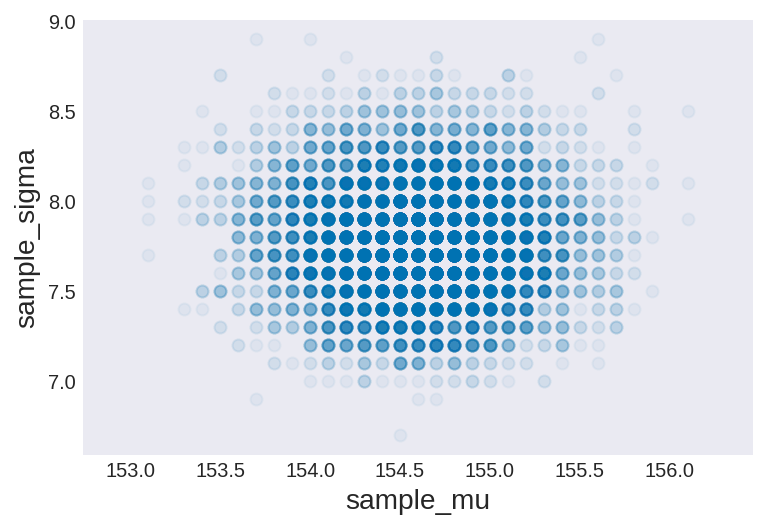

In [166]:
sample_rows = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu = post[:,0][sample_rows]
sample_sigma = post[:,1][sample_rows]

plt.plot(sample_mu, sample_sigma, 'o', alpha=0.05)
plt.axis('equal')
plt.grid(False)
plt.xlabel('sample_mu', fontsize=14)
plt.ylabel('sample_sigma', fontsize=14);

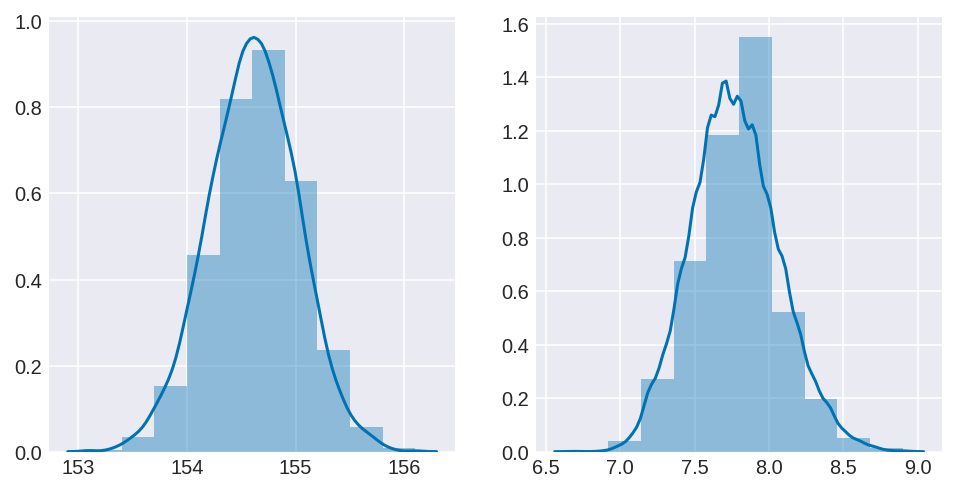

In [175]:
_, (ax0,ax1) = plt.subplots(1,2, figsize=(8,4))
sns.distplot(sample_mu,norm_hist=True,bins=10,ax=ax0)
sns.distplot(sample_sigma,norm_hist=True,bins=10,ax=ax1)

In [176]:
pm.hpd(sample_mu), pm.hpd(sample_sigma)


(array([153.8, 155.4]), array([7.3, 8.4]))

In [197]:
d3 = np.random.choice(d2.height, 10)
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

likelihood2 = [sum(stats.norm.logpdf(d3, loc=post[:,0][i], scale=post[:,1][i])) for i in range(len(post))]

post_prod2 = (likelihood + 
              stats.norm.logpdf(post[:,0], loc=178, scale=20) + 
              stats.uniform.logpdf(post[:,1], loc=0, scale=50))

post_prob2 = np.exp(post_prod - max(post_prod))

sample_rows2 = np.random.choice(np.arange(len(post)), size=10000, replace=True, 
                               p=(post_prob/post_prob.sum()))
sample_mu2 = post[:,0][sample_rows]
sample_sigma2 = post[:,1][sample_rows]


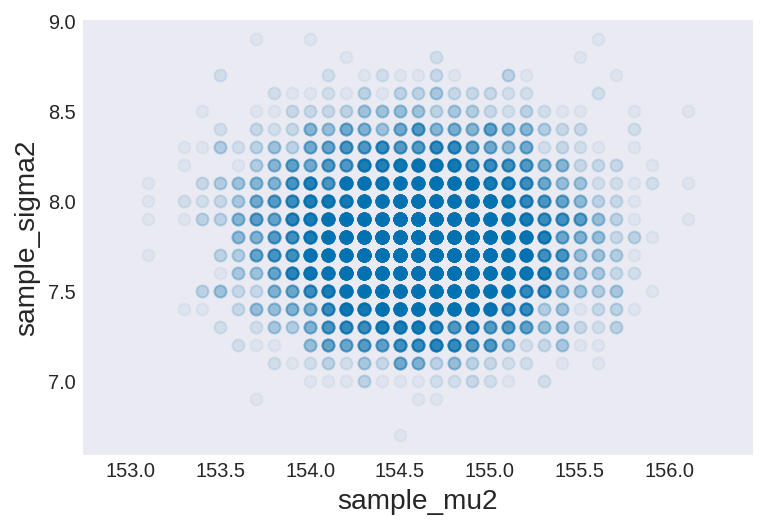

In [198]:
plt.plot(sample_mu2, sample_sigma2, 'o', alpha=0.05)
plt.axis('equal')
plt.xlabel('sample_mu2', fontsize=14)
plt.ylabel('sample_sigma2', fontsize=14)
plt.grid(False)

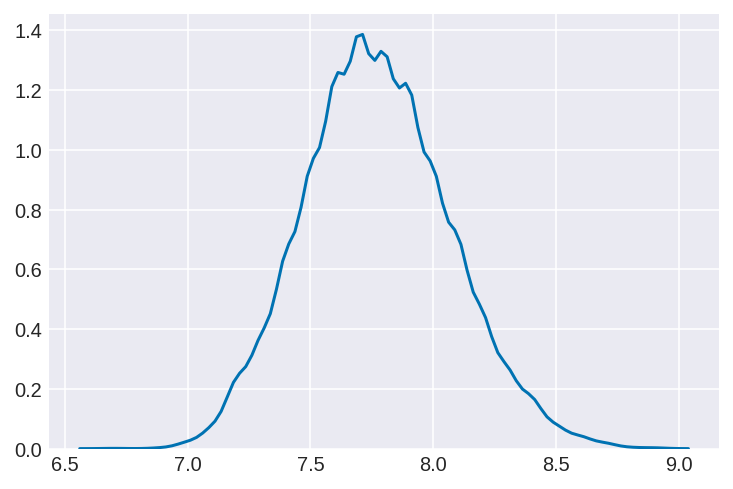

In [199]:
sns.distplot(sample_sigma2,kde=True,hist=False)

### Now, let's use the quadratic approximation instead of the grid method.

In [229]:
with pm.Model() as normal_approximation:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma',lower=0,upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    mean_h = pm.find_MAP()
    std_h  = ((1/pm.find_hessian(mean_h,vars=[mu,sigma]))**0.5) #The hessian matrix is used to get the
                                                                #derivatives in terms of the variables

logp = -1,235.2, ||grad|| = 11.697: 100%|██████████| 19/19 [00:00<00:00, 1931.36it/s]  


{'sigma': array(7.73133303), 'sigma_interval__': array(-1.69876478), 'mu': array(154.60702358)}
mu standard dev = 0.41199399266738285
sigma standard dev = 0.29138557484355165


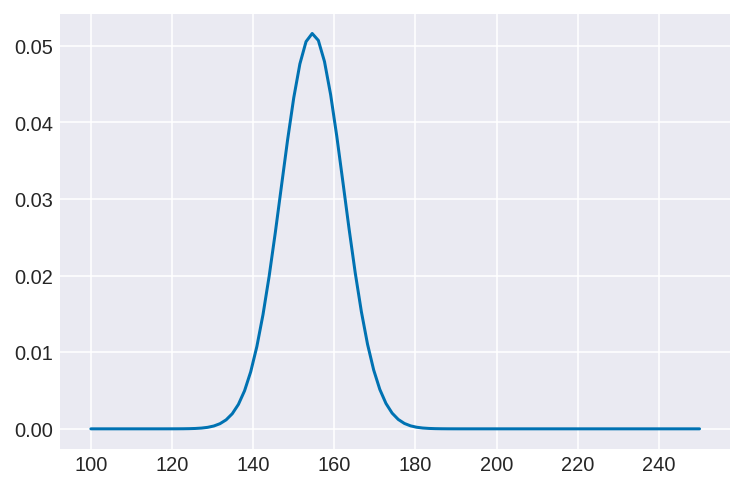

In [242]:
x = np.linspace(100, 250, 100)
print(mean_h)
print('mu standard dev =',std_h[0][0])
print('sigma standard dev =',std_h[1][1])
plt.plot(x, stats.norm.pdf(x, mean_h['mu'],mean_h['sigma']))

### Another way to get the posterior is using Markov Chain Monte Carlo sampling, as shown below.

In [243]:
with normal_approximation:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/davi/Envs/machinepy3/machinepy3/lib/python3.5/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1305.42it/s]


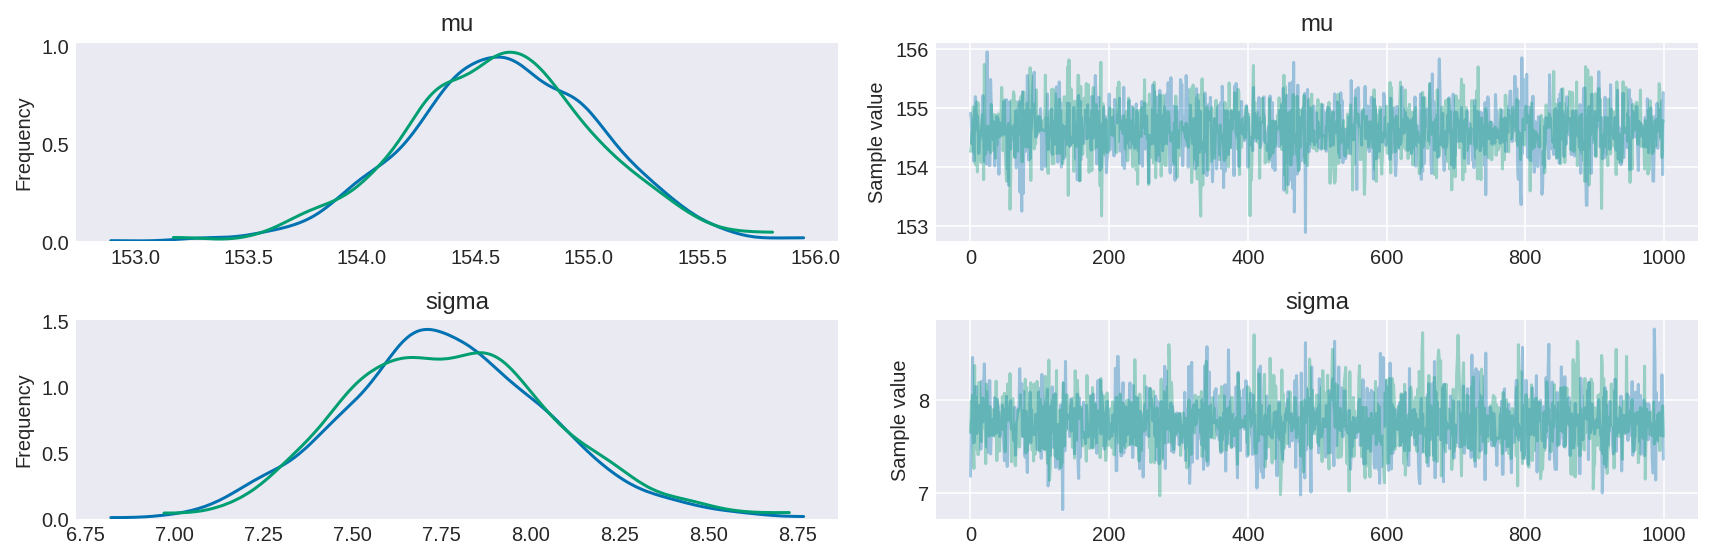

In [244]:
pm.traceplot(trace_4_1); # this function let you check the samples values

In [247]:
np.average(trace_4_1['mu'])
np.average(trace_4_1['mu'])

154.61187217789004